In [1]:
import xarray as xr
import numpy as np
import xskillscore
import cartopy.crs as ccrs

import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

In [2]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

In [3]:
runs_configs = {
    "diffusion": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_09-45-42"),
    "diffusion_10Members": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_10-29-54"),
    "diffusion_CosineAnnealing": ("rasp_thuerey_z_500_3day",  "diffusion_CosineAnnealing", "2023-09-13_22-56-04", "2023-09-14_09-51-06"),
    "diffusion_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_deeper", "2023-09-13_20-06-24", "2023-09-14_09-46-02"),
    "diffusion_wider": ("rasp_thuerey_z_500_3day",  "diffusion_wider", "2023-09-13_20-04-33", "2023-09-14_09-46-01"),
    "diffusion_MSE_Loss": ("rasp_thuerey_z_500_3day",  "diffusion_MSE_Loss", "2023-09-13_21-22-12", "2023-09-14_09-52-21"),
    "diffusion_2csteps": ("rasp_thuerey_z_500_3day_2csteps",  "diffusion_2csteps", "2023-09-13_22-18-16", "2023-09-14_10-09-09"),
    "diffusion_fourcast": ("rasp_thuerey_z_500_3day",  "diffusion_fourcast", "2023-09-16_13-59-43", "2023-09-17_20-29-06"),
    "diffusion_more_patient_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_more_patient_deeper", "2023-09-14_14-38-48", "2023-09-18_11-57-55"),
    "diffusion_t_850_3day": ("rasp_thuerey_t_850_3day",  "diffusion_t_850_3day", "2023-09-15_16-51-22", "2023-09-18_11-04-53"),

}

predictions = dict()
targets = dict()
diff = dict()

for key, r_config in runs_configs.items():
    targets[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format(*r_config))
    predictions[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format(*r_config))
    diff[key] = targets[key] - predictions[key]

In [7]:
for key in runs_configs.keys():
    rmse = compute_weighted_rmse(predictions[key].isel({"ensemble_member": 0}), targets[key].isel({"ensemble_member": 0}))
    print("RMSE {} is {:.1f}".format(key, rmse.z_500.values))

RMSE diffusion is 679.6
RMSE diffusion_10Members is 679.2
RMSE diffusion_CosineAnnealing is 675.8
RMSE diffusion_deeper is 671.1
RMSE diffusion_wider is nan
RMSE diffusion_MSE_Loss is 646.4
RMSE diffusion_2csteps is 691.8
RMSE diffusion_fourcast is 642.5
RMSE diffusion_more_patient_deeper is 594.7


# Ensemble Analysis

### Mean of ensemble rmse vs rmse of mean ensemble

In [4]:
k = "diffusion_more_patient_deeper"

rmse_ensemble_mean = compute_weighted_rmse(predictions[k].mean("ensemble_member"), targets[k].mean("ensemble_member"))

rmse = []
for i in range(len(predictions[k].ensemble_member)):
    rmse.append(compute_weighted_rmse(predictions[k].isel({"ensemble_member": i}), targets[k].isel({"ensemble_member": 0})))

mean_of_ensemble_rmse = np.mean([r.z_500.values for r in rmse])
std_of_ensemble_rmse = np.std([r.z_500.values for r in rmse])


print(f"RMSE of ensemble Mean: {rmse_ensemble_mean.z_500.values:.1f}")
print(f"Ensemble of RMSEs: {mean_of_ensemble_rmse:.1f} +/- {std_of_ensemble_rmse:.1f}")

RMSE of ensemble Mean: 566.6
Ensemble of RMSEs: 595.0 +/- 0.3


### Wihout Area weighted

In [5]:
rmse_ensemble_mean = compute_rmse(predictions[k].mean("ensemble_member"), targets[k].mean("ensemble_member"))

rmse = []
for i in range(len(predictions[k].ensemble_member)):
    rmse.append(compute_rmse(predictions[k].isel({"ensemble_member": i}), targets[k].isel({"ensemble_member": 0})))

mean_of_ensemble_rmse = np.mean([r.z_500.values for r in rmse])
std_of_ensemble_rmse = np.std([r.z_500.values for r in rmse])


print(f"RMSE of ensemble Mean: {rmse_ensemble_mean.z_500.values:.1f}")
print(f"Ensemble of RMSEs: {mean_of_ensemble_rmse:.1f} +/- {std_of_ensemble_rmse:.1f}")

NameError: name 'compute_rmse' is not defined

# RMSE/var plots:

In [10]:
error2 = [(targets[k].isel({"ensemble_member":0}) - predictions[k].isel({"ensemble_member":i})) **2 for i in range(len(predictions[k].ensemble_member))]
error2_sum = error2[0]
for i in range(len(predictions[k].ensemble_member)-1):
    error2_sum+=error2[i+1]

rmse = np.sqrt(error2_sum/10)

rmse_var_ratio = rmse / predictions[k].std("ensemble_member")

In [59]:
ranks = xskillscore.rank_histogram(targets[k].isel({"ensemble_member":0}), predictions[k], member_dim="ensemble_member", dim=["init_time", "lead_time"])

In [57]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!


config = {
    "CMAP": matplotlib.colors.ListedColormap(["#fff7ec", "#f7fcfd", "#e0ecf4", "#bfd3e6", "#9ebcda", "#8c96c6", "#8c6bb1", "#88419d", "#810f7c", "#4d004b"]),
    "BOUNDS": np.array([0,1, 1.5, 2, 2.5, 3, 3.5,4,4.5,5]),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "max",
    "SHOW_COLORBAR_LABEL": True,
    "CBAR_LABEL": r"$RMSE / \sigma_{ensemble}$ [1]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 5.5/5  # can be used to calculate a figsize that looks nice for a given type of plot
}

config["NORM"] = matplotlib.colors.BoundaryNorm(config["BOUNDS"], config["CMAP"].N)


config_rmse = copy.deepcopy(config)
config_rmse["CMAP"] = "Reds"
config_rmse["NORM"] = matplotlib.colors.Normalize(vmin=0, vmax=1000)
config_rmse["CBAR_LABEL"] = r"Geopotential [$m^2/s^2$]"

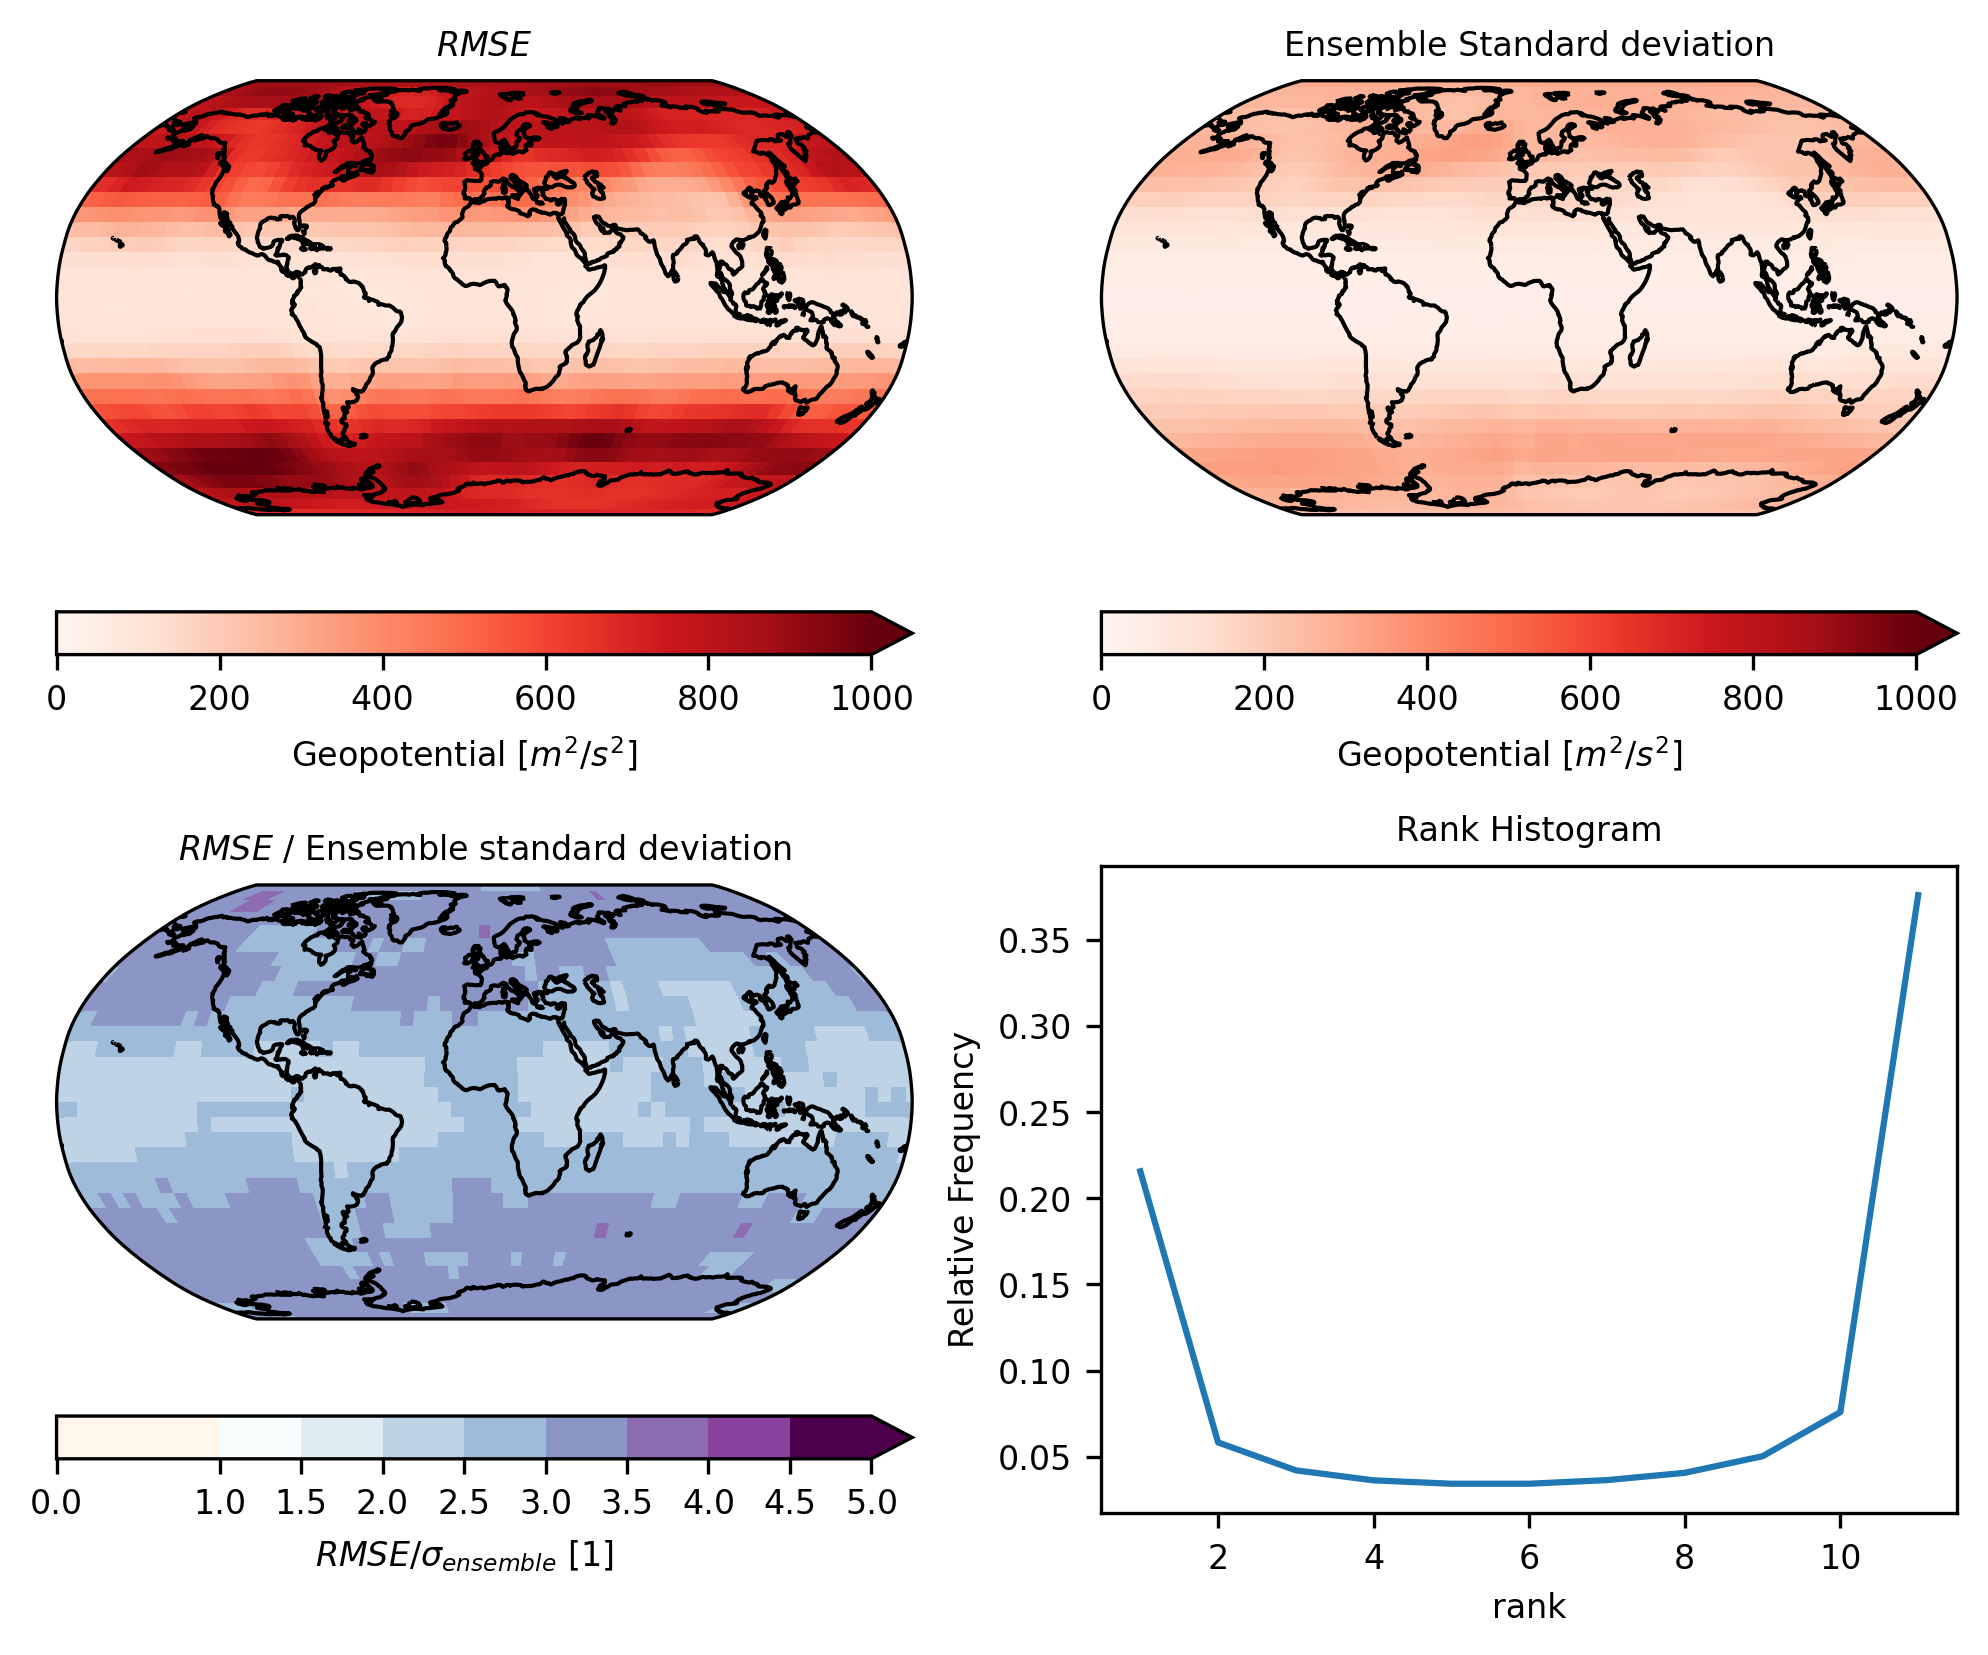

In [71]:
n_rows = 2
n_cols = 2

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"] * 0.9

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1])


ax = fig.add_subplot(gs[0, 0], projection=config["PROJECTION"])
# plot the map:
plot_map(ax, data=rmse.isel({"lead_time":0}).mean("init_time")[["z_500"]], plotting_config=config_rmse, title=r"$RMSE$")

ax = fig.add_subplot(gs[0, 1], projection=config["PROJECTION"])
# plot the map:
plot_map(ax, data=predictions[k].std("ensemble_member").isel({"lead_time":0}).mean("init_time")[["z_500"]], plotting_config=config_rmse, title=r"Ensemble Standard deviation")


ax = fig.add_subplot(gs[1, 0], projection=config["PROJECTION"])
# plot the map:
plot_map(ax, data=rmse_var_ratio.isel({"lead_time":0}).mean("init_time")[["z_500"]], plotting_config=config, title=r"$RMSE$ / Ensemble standard deviation")

ax = fig.add_subplot(gs[1, 1])
# plot the map:
(ranks.sum(("lat","lon"))/ranks.sum()).z_500.plot(ax=ax)
ax.set_ylabel("Relative Frequency")
ax.set_title("Rank Histogram", fontsize=config["TITLE_FONTSIZE"])

fig.canvas.draw()
fig.tight_layout()

plt.savefig("images/ensemble_stats.jpg")

### CRPS Score

In [16]:
crps = xskillscore.crps_ensemble(targets[k].isel({"ensemble_member":0}), predictions[k], member_dim="ensemble_member", dim=["init_time", "lead_time"])

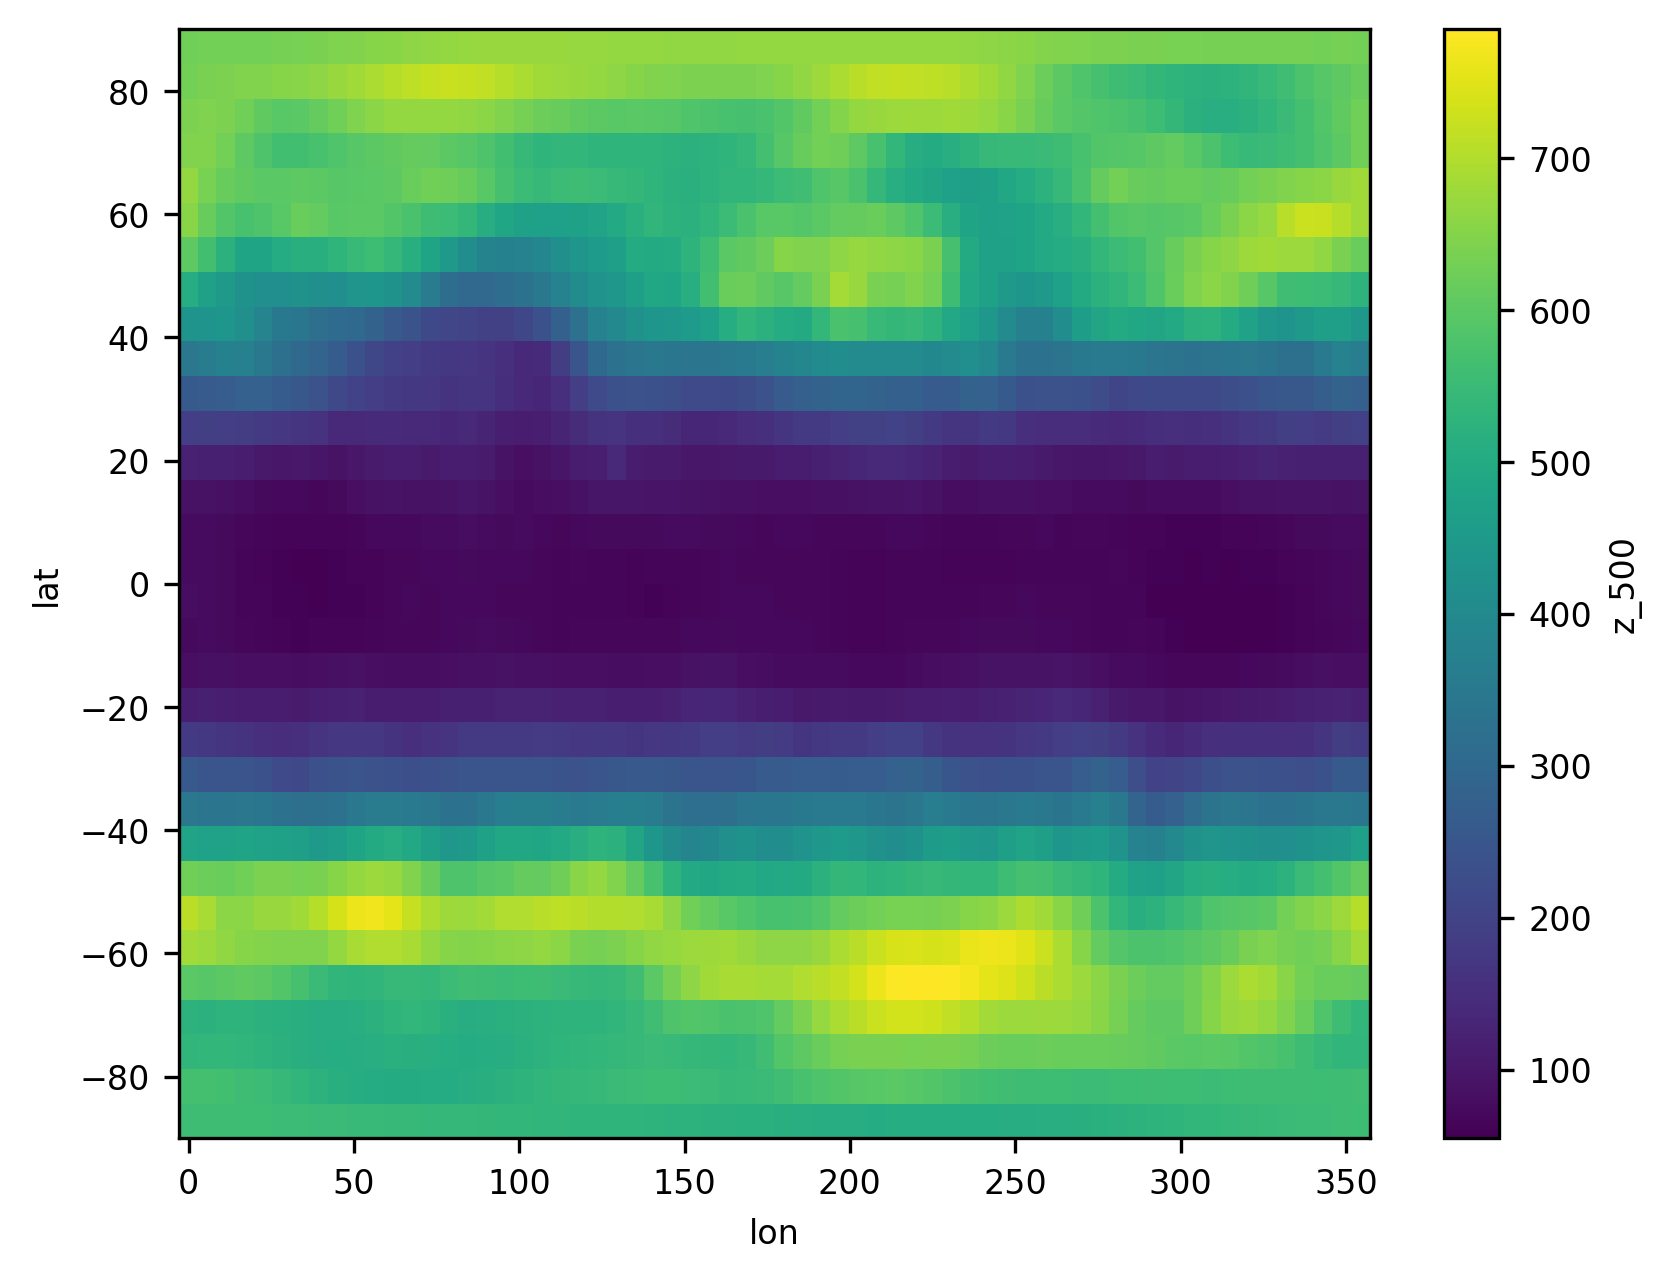

In [18]:
crps.z_500.plot()